# Benchmark Study Data Preparation

### Initial Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import pickle

c:\Users\e77jo\Documents\420-DBM\dbenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#columns are consistent but the dtypes when loading are not - 
#so we'll hardcode them here

dtype_dict = {
    'Unnamed: 0': int,
    'author_id': str,
    'rating': float,
    'total_feedback_count': int,
    'total_neg_feedback_count': int,
    'total_pos_feedback_count': int,
    'submission_time': str, 
    'review_text': str,
    'review_title': str, 
    'skin_tone': str, 
    'eye_color': str, 
    'skin_type': str, 
    'hair_color': str,
    'product_id': str, 
    'product_name': str, 
    'brand_name': str, 
    'price_usd': float
}

files = [f for f in os.listdir() if f.startswith('reviews')]
reviews = pd.concat(map(lambda x: pd.read_csv(x, dtype=dtype_dict, parse_dates=['submission_time']), files))

#unnamed: 0 is a redundant index column, it can be removed
reviews = reviews.iloc[:, 1:]
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1094411 entries, 0 to 119316
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   author_id                 1094411 non-null  object        
 1   rating                    1094411 non-null  float64       
 2   is_recommended            926423 non-null   float64       
 3   helpfulness               532819 non-null   float64       
 4   total_feedback_count      1094411 non-null  int32         
 5   total_neg_feedback_count  1094411 non-null  int32         
 6   total_pos_feedback_count  1094411 non-null  int32         
 7   submission_time           1094411 non-null  datetime64[ns]
 8   review_text               1092967 non-null  object        
 9   review_title              783757 non-null   object        
 10  skin_tone                 923872 non-null   object        
 11  eye_color                 884783 non-null   object      

In [3]:
reviews.head()

,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,1741593524,5.0,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,31423088263,1.0,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,5061282401,5.0,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,6083038851,5.0,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,47056667835,5.0,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [4]:
#check for duplicate texts
reviews[reviews['review_text'].duplicated(keep=False) == True].sort_values('review_text').head(10)

,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
96290,6796719930,5.0,1.0,NaN,0,0,0,2021-08-31,!!! Gifted by Rose Inc. it was really gentle ...,Absolutely amazing product !!,fairLight,brown,combination,brown,P504315,Mini Skin Resolution Clarifying Acid Toner,ROSE INC,15.0
96106,6796719930,5.0,1.0,NaN,0,0,0,2021-08-31,!!! Gifted by Rose Inc. it was really gentle ...,Absolutely amazing product !!,fairLight,brown,combination,brown,P476010,Skin Resolution Clean Exfoliating Acid Toner,ROSE INC,32.0
207606,1787393718,5.0,1.0,1.0,2,0,2,2020-08-17,!!!!!!!!!! This toner is beyond amazing. I hav...,it really works,fair,blue,oily,blonde,P458219,Watermelon Glow PHA + BHA Pore-Tight Toner,Glow Recipe,34.0
210927,1787393718,5.0,1.0,1.0,2,0,2,2020-08-17,!!!!!!!!!! This toner is beyond amazing. I hav...,it really works,fair,blue,oily,blonde,P467762,Mini Watermelon Glow PHA + BHA Pore-Tight Toner,Glow Recipe,15.0
56622,6858714422,5.0,1.0,1.0,1,0,1,2020-11-11,!WOW! melts all my makeup away so easily. love...,STOP THE DOUBT! JUST BUY IT!,mediumTan,brown,oily,black,P417238,Green Clean Makeup Removing Cleansing Balm,Farmacy,36.0
62791,6858714422,5.0,1.0,1.0,1,0,1,2020-11-11,!WOW! melts all my makeup away so easily. love...,STOP THE DOUBT! JUST BUY IT!,mediumTan,brown,oily,black,P450271,Green Clean Makeup Meltaway Cleansing Balm Lim...,Farmacy,60.0
60979,1425140904,5.0,1.0,NaN,0,0,0,2019-03-12,# I’ve received this product as a free sample ...,love it! seeing a result.,fair,brown,normal,black,P440650,Mini Retinol Youth Renewal Serum,Murad,32.0
40783,1425140904,5.0,1.0,NaN,0,0,0,2019-03-12,# I’ve received this product as a free sample ...,love it! seeing a result.,fair,brown,normal,black,P411365,Retinol Youth Renewal Serum,Murad,92.0
576283,1755063609,5.0,1.0,NaN,0,0,0,2021-10-13,#DermalogicagiftedmeI use it before washing my...,Removed my eye makeup a lots easier,light,brown,combination,auburn,P443350,Mini Precleanse Cleansing Oil,Dermalogica,15.0
575053,1755063609,5.0,1.0,NaN,0,0,0,2021-10-13,#DermalogicagiftedmeI use it before washing my...,Removed my eye makeup a lots easier,light,brown,combination,auburn,P423148,Precleanse Cleansing Oil,Dermalogica,49.0


Duplicate rows were flagged in Kaggle but I guess that hasn't been addressed by the dataset owner yet. 
We can just remove these here. 

In [5]:
reviews.drop_duplicates(subset='review_text', keep='first', inplace=True)
reviews.shape

(969420, 18)

<Axes: ylabel='None'>

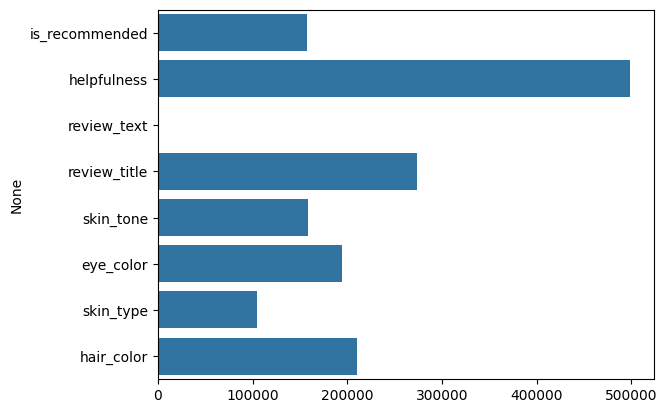

In [6]:
df_nulls = reviews.loc[:, reviews.isnull().any()]

plot_nulls = df_nulls.isna().sum()
sns.barplot(x=plot_nulls.values, y=plot_nulls.index)

In [7]:
reviews['is_recommended'].value_counts(normalize=True)

is_recommended
1.0    0.841864
0.0    0.158136
Name: proportion, dtype: float64

I don't want to distort this dataset too much. About 50% of the helpfulness field is missing.
Through the process of creating an index of embeddings, we'll be using a competing method for helpfulness that includes the text.
Leaving in all these missing values for helpfulness could create bias in the results of our study. 

The is_recommended field is about a user event that's boolean as opposed to a floating point scale. 
For this project we can assume that the missing fields can be denoted as 0, or not recommended. 

About 1/3 of the data doesn't have a title. The title is not crucial to our analysis. 
A good remedy here would be to combine these two fields so that each record is one document. 

The other categorical fields are personal details, we can input "Unknown" for these missing values.

The reviews with nulls can be dropped -- that part is valuable to be completely full. 

In [8]:
#removing helpfulness
reviews.drop(columns=['helpfulness'], axis=1, inplace=True)

#fill missing recommended with 0
reviews['is_recommended'] = reviews['is_recommended'].fillna(0)

#combine review text & title
reviews['review_full'] = reviews['review_title'].fillna('') + ' ' + reviews['review_text']
#this creates whitespace where titles are missing.
reviews['review_full'] = reviews['review_full'].str.strip()
reviews.drop(columns=['review_title', 'review_text'], axis=1, inplace=True)

categories = ['skin_tone', 'skin_type', 'eye_color', 'hair_color']

for col in categories:
    reviews[col] = reviews[col].fillna('Unknown')

reviews.dropna(axis=0, inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 969419 entries, 0 to 119316
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   author_id                 969419 non-null  object        
 1   rating                    969419 non-null  float64       
 2   is_recommended            969419 non-null  float64       
 3   total_feedback_count      969419 non-null  int32         
 4   total_neg_feedback_count  969419 non-null  int32         
 5   total_pos_feedback_count  969419 non-null  int32         
 6   submission_time           969419 non-null  datetime64[ns]
 7   skin_tone                 969419 non-null  object        
 8   eye_color                 969419 non-null  object        
 9   skin_type                 969419 non-null  object        
 10  hair_color                969419 non-null  object        
 11  product_id                969419 non-null  object        
 12  product

In [9]:
#the value for not sure should be unknown for consistence
reviews.loc[reviews['skin_tone'] == 'notSureST', 'skin_tone'] = 'Unknown'
reviews['skin_tone'].value_counts()

skin_tone
light          234603
fair           182821
lightMedium    172258
Unknown        158415
medium          61739
mediumTan       54605
fairLight       49241
tan             29467
deep            17982
rich             4748
olive            1573
porcelain        1485
dark              479
ebony               3
Name: count, dtype: int64

In [10]:
#combining grey and gray
reviews.loc[reviews['eye_color'] == 'Grey', 'eye_color'] = 'gray'
reviews['eye_color'].value_counts()

eye_color
brown      411927
Unknown    194467
blue       151071
hazel      103770
green      103369
gray         4815
Name: count, dtype: int64

In [11]:
reviews['skin_type'].value_counts()

skin_type
combination    479177
dry            163501
normal         116434
oily           105913
Unknown        104394
Name: count, dtype: int64

In [12]:
#brown and brunette mean the same thing
reviews.loc[reviews['hair_color'] == 'brunette', 'hair_color'] = 'brown'
reviews['hair_color'].value_counts()

hair_color
brown      361360
Unknown    210293
blonde     178613
black      164462
auburn      27409
red         22503
gray         4779
Name: count, dtype: int64

In [13]:
reviews.head()

,author_id,rating,is_recommended,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd,review_full
0,1741593524,5.0,1.0,2,0,2,2023-02-01,Unknown,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0,Taught me how to double cleanse! I use this wi...
1,31423088263,1.0,0.0,0,0,0,2023-03-21,Unknown,Unknown,Unknown,Unknown,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Disappointed I bought this lip mask after read...
2,5061282401,5.0,1.0,0,0,0,2023-03-21,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,New Favorite Routine My review title says it a...
3,6083038851,5.0,1.0,0,0,0,2023-03-20,Unknown,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,Can't go wrong with any of them I’ve always lo...
4,47056667835,5.0,1.0,0,0,0,2023-03-20,light,hazel,combination,Unknown,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0,"A must have !!! If you have dry cracked lips, ..."


1218


<Axes: ylabel='review_full'>

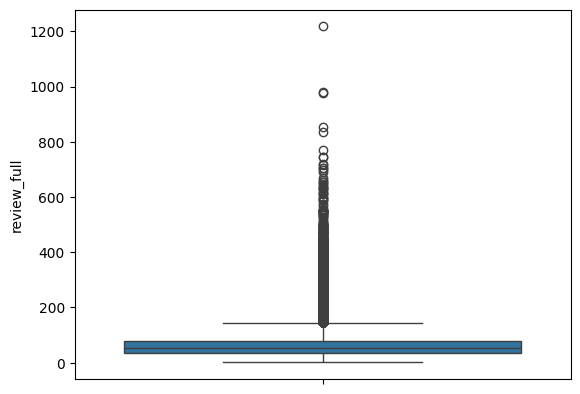

In [14]:
#what's the max word count we're dealing with? 
word_count = reviews['review_full'].apply(lambda x: len(x.split(' ')))
print(word_count.max())
sns.boxplot(word_count)

The max word count appears to be an outlier.

A model with the max seq length of 512 should work well enough with some truncation for the longer documents. 

We'll use multi-qa-MiniLM-L6-cos-v1 since it has a good mix of speed and performance on search tasks. 
[found here](https://www.sbert.net/docs/pretrained_models.html)

### Generating Embeddings

Pinecone has a limited free tier to 100,000 vectors, and mongoDB has a storage limit of 512 MB, we'll have to reduce this to 90k rows

In [15]:
sample_df = reviews.sample(n=90000, random_state=42)

In [16]:
#running without cuda will take a really long time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1', device=device)

In [17]:
"""
This code generates the embeddings & associated .npy file
Only need to run once, then you can comment out this cell. 
"""
sents = sample_df['review_full'].to_list()
embeddings = [model.encode([sent]) for sent in tqdm(sents)]
np.save('sephora-embeddings.npy', np.array(embeddings))

  0%|          | 0/90000 [00:00<?, ?it/s]

100%|██████████| 90000/90000 [09:19<00:00, 160.91it/s]


In [18]:
embeddings = np.load('sephora-embeddings.npy')

In [19]:
#gets us out of the ndarray
sample_df['embeddings'] = embeddings.tolist()
#gets us one list vs a nested list
sample_df['embeddings'] = sample_df['embeddings'].explode()

#got an error when loading that pinecone wants the embeddings to be called 'values'
sample_df = sample_df.rename(columns={'embeddings': 'values'})
sample_df.head()

,author_id,rating,is_recommended,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd,review_full,values
500342,1638412469,5.0,0.0,0,0,0,2009-05-13,light,Unknown,oily,Unknown,P114902,Goodbye Acne Max Complexion Correction Pads,Peter Thomas Roth,48.0,"love the burn It burns, but it works. My pores...","[0.0030438287649303675, 0.004472009371966124, ..."
87460,5923299079,4.0,1.0,0,0,0,2022-01-07,lightMedium,brown,combination,brown,P479348,Acne+ 2% BHA and Azelaic Acid Acne Spot Treatment,Skinfix,30.0,Great product ! Ive been testing this for abou...,"[-0.03229909762740135, 0.03269119933247566, 0...."
95852,1366210511,5.0,0.0,1,0,1,2015-05-05,Unknown,Unknown,Unknown,Unknown,P309308,Good Genes All-In-One AHA Lactic Acid Treatment,Sunday Riley,122.0,BEST EVER This is my first review on a product...,"[-0.10494845360517502, -0.0864892229437828, 0...."
203782,7371812273,5.0,0.0,20,1,19,2017-08-16,Unknown,Unknown,Unknown,Unknown,P421432,Rapid Relief Acne Spot Treatment,Murad,26.0,"just wow ! Sooo, I never write reviews but tod...","[-0.0588916577398777, 0.05740262195467949, 0.0..."
490979,6226064067,5.0,0.0,58,4,54,2015-01-18,Unknown,Unknown,combination,Unknown,P54509,Tonique Confort Re-Hydrating Comforting Toner ...,Lancôme,39.0,OMG! FINALLY a toner that is totally moisturiz...,"[-0.07242435216903687, 0.05376826226711273, 0...."


### Creating the data index

In [20]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90000 entries, 500342 to 367527
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   author_id                 90000 non-null  object        
 1   rating                    90000 non-null  float64       
 2   is_recommended            90000 non-null  float64       
 3   total_feedback_count      90000 non-null  int32         
 4   total_neg_feedback_count  90000 non-null  int32         
 5   total_pos_feedback_count  90000 non-null  int32         
 6   submission_time           90000 non-null  datetime64[ns]
 7   skin_tone                 90000 non-null  object        
 8   eye_color                 90000 non-null  object        
 9   skin_type                 90000 non-null  object        
 10  hair_color                90000 non-null  object        
 11  product_id                90000 non-null  object        
 12  product_name     

In [21]:
#drop what we don't need
#had some errors with date fields, removing them here. 
#sentiment related columns contain information we can glean from the vector embeddings.
sample_df = sample_df.reset_index().drop(columns=['index', 'author_id', 'submission_time', 'product_id', 
                                                  'total_feedback_count', 'total_pos_feedback_count', 
                                                  'total_neg_feedback_count', 'is_recommended'])

In [22]:
data = [{'id': str(i), 
         'values': row['values'], 
         'metadata': row.drop('values').to_dict()} 
        for i, row in sample_df.iterrows()]

In [23]:
data[0]

{'id': '0',
 'values': [0.0030438287649303675,
  0.004472009371966124,
  0.07097481191158295,
  0.08143029361963272,
  0.06849981844425201,
  -0.050113920122385025,
  0.053455207496881485,
  0.05649996176362038,
  -0.059897530823946,
  -0.07594893872737885,
  -0.07218535244464874,
  -0.05941902473568916,
  -0.04102000966668129,
  0.011415235698223114,
  -0.032470304518938065,
  -0.001875639776699245,
  0.00520893931388855,
  0.0221845805644989,
  0.013776568695902824,
  -0.062185246497392654,
  -2.2982243535807356e-05,
  0.0024249497801065445,
  0.01610706001520157,
  -0.026995105668902397,
  0.0351138599216938,
  -0.04917909950017929,
  0.04377542808651924,
  -0.044541969895362854,
  -0.00423040334135294,
  -0.0278280321508646,
  -0.014061996713280678,
  0.03423372656106949,
  -0.11560318619012833,
  0.00688050827011466,
  -0.03010465018451214,
  -0.08874853700399399,
  -0.07482282817363739,
  0.04685718193650246,
  -0.025644252076745033,
  0.03786584362387657,
  0.07492639869451523,


In [24]:
with open('sephora-index.pkl', 'wb') as f:
    pickle.dump(data, f)

### Investigating the data from results in test queries

Ran into something where a review about shampoo is linked to a product name of eye cream, 
I want to confirm this is an issue with the underlying data as opposed to an error in the set up

In [25]:
sample_df.loc[sample_df['review_full'] == 'I have heard so many great things about DryBar so I was so excited to try this shampoo. First best thing I noticed was that a little product goes a very long way. I only put a small amount for my hair and it built up so much suds. Perfect for on the go especially when you have a smaller size bottle.']

,rating,skin_tone,eye_color,skin_type,hair_color,product_name,brand_name,price_usd,review_full,values
35796,5.0,mediumTan,brown,combination,brown,Eye Revival Brightening Eye Cream,ROSE INC,55.0,I have heard so many great things about DryBar...,"[-0.06459730118513107, -0.014318501576781273, ..."


In [26]:
reviews.loc[reviews['review_full'] == 'I have heard so many great things about DryBar so I was so excited to try this shampoo. First best thing I noticed was that a little product goes a very long way. I only put a small amount for my hair and it built up so much suds. Perfect for on the go especially when you have a smaller size bottle.']

,author_id,rating,is_recommended,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd,review_full
94013,6103785956,5.0,1.0,9,9,0,2022-06-28,mediumTan,brown,combination,brown,P500696,Eye Revival Brightening Eye Cream,ROSE INC,55.0,I have heard so many great things about DryBar...


In [27]:
sample_df.loc[sample_df['review_full'].str.contains('shampoo') == True]['product_name'].value_counts()

product_name
100 percent Pure Argan Oil                                          5
Secret Sauce Moisturizer                                            1
Facial Radiance Pads                                                1
Checks and Balances Frothy Face Wash                                1
Pure Skin Face Cleanser                                             1
Salicylic Acid Acne + Pore Cleanser                                 1
Crème Radiance Gentle Cleansing Creamy-Foam Cleanser                1
The Deep Cleanse Gentle Exfoliating Cleanser                        1
Take The Day Off Cleansing Balm Makeup Remover                      1
100% Plant-Derived Hemi-Squalane                                    1
Foam Around Clarifying Daily Cleanser Infused with Glycolic Acid    1
Honeymoon Glow AHA Resurfacing Night Serum                          1
Purifying Pore Detox Cleanser                                       1
SEA drink of H2O hydrating boost moisturizer                        1
E-Rase 

In [28]:
for review in sample_df.loc[sample_df['review_full'].str.contains('shampoo') == True]['review_full'][:25]:
    print(review)

Great until it isn't It goes on great and doesn’t give me the usual redness when using cream and moisturizes well.  However, as some of the reviews already pointed out, it somehow give me acne/pimples weirdly specific in the forehead area.  The kind that hurts and can be popped.  I have mature skin and never got forehead acne even during puberty.   It took me half a jar to figure out the cream being the culprit as I thought it was the shampoo I was using.
Finally cleared up my skin! I’ve been struggling to find something non-irritating to clear up some breakouts and this is it! I have sensitive skin that reacts poorly to a lot of soaps (I’m actively allergic to shampoo) but this is my holy grail face wash
more than just a hydrator! This is a must in my makeup kit! First and foremost my clients love it;the soft scent of roses, truly a refreshing aromatherapy. Also, seconds a pick me up when you feel tired, and thirds as a refresher for hair that is not too fresh and needs a gently smell

In [29]:
sample_df.loc[sample_df['product_name'].str.contains('shampoo') == True]['review_full']

Series([], Name: review_full, dtype: object)

In [30]:
reviews.loc[reviews['product_name'].str.contains('shampoo') == True]['review_full']

Series([], Name: review_full, dtype: object)

- Sure enough, this was an error from when scraping. It's unclear how much of the data this impacts. But it doesn't appear to be widesperad. 
- Shampoo appears to be in the text of many reviews about non-shampoo products - shampoo is mentioned as an aside rather than being the focal point of the review. 
- There aren't products that contain the name shampoo in the sample dataset nor the full dataset -- that's likely a gap in what was scraped from sephora's website. 

### Some visualizations to aid the presentation

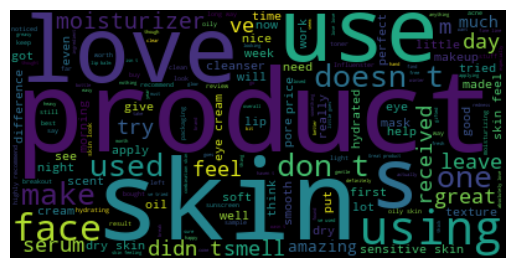

In [31]:
from wordcloud import WordCloud, STOPWORDS
import string

text = " ".join(review for review in sample_df['review_full']) 
text = text.translate(str.maketrans('', '', string.punctuation))
wordcloud = WordCloud(stopwords=set(STOPWORDS)).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

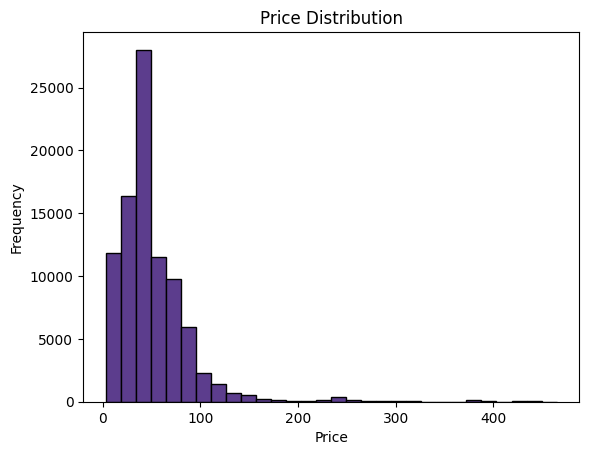

In [32]:
plt.hist(sample_df['price_usd'], bins=30, edgecolor='black', color="#5c3d8d")
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

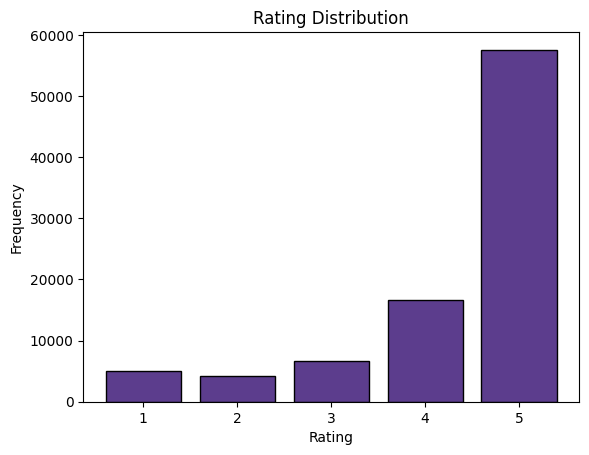

In [33]:
rating_counts = sample_df['rating'].value_counts()

plt.bar(rating_counts.index, rating_counts.values, edgecolor='black', color="#5c3d8d")
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

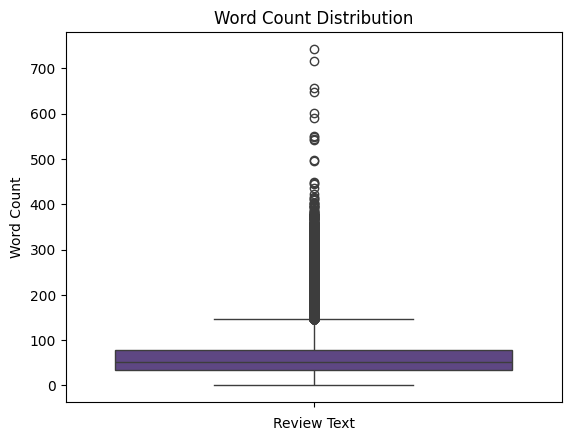

In [34]:
#making the boxplot prettier
word_count = sample_df['review_full'].apply(lambda x: len(x.split(' ')))
sns.boxplot(word_count, color="#5c3d8d")
plt.title('Word Count Distribution')
plt.xlabel('Review Text')
plt.ylabel('Word Count')
plt.show()

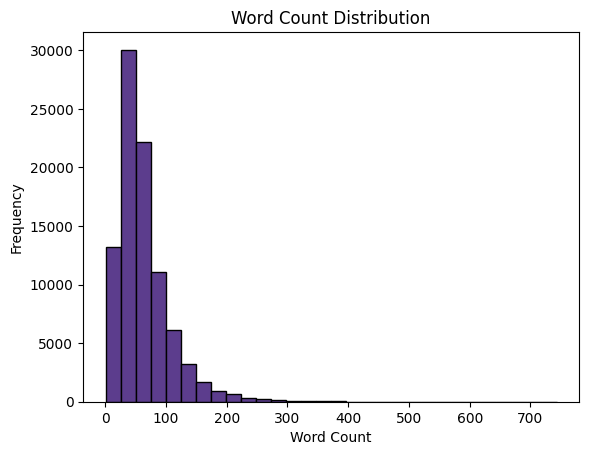

In [35]:
plt.hist(word_count, bins=30, color="#5c3d8d", edgecolor='black')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()